# Create db from scraped data

## Imports

In [1]:
import glob
import json
import re

import networkx as nx
from itertools import combinations

## Read raw API call files

Reads all the stored API call files and compiles them into a more useful DataFrame.

In [2]:
user_map = {}
transaction_map = {}

for f_name in tqdm(glob.glob('data/raw/*.json')):
    with open(f_name, 'r') as f:
        data = json.load(f)
        for entry in data['data']:
            actor = entry['actor']
            
            assert(len(entry['transactions']) == 1)
            transaction = entry['transactions'][0]
            target = transaction['target']
            if (target in ['a phone number', 'an email'] or
                target.get('name') == 'a user on iMessage'):
                continue
            
            # custom entries
            entry['from'] = int(actor['id'])
            entry['to'] = int(target['id'])

            user_map[int(actor['id'])] = actor
            user_map[int(target['id'])] = target
            transaction_map[entry['story_id']] = entry

NameError: name 'tqdm' is not defined

In [417]:
transactions = pd.DataFrame().from_dict(transaction_map, orient='index')[[
     'created_time',
     'from',
     'to',
     'message',
     'type',
     'payment_id',
     'permalink',
     'via',
     'story_id',
     'updated_time',
     'audience',
]]
transactions['created_time'] = pd.to_datetime(transactions.created_time)

users = pd.DataFrame().from_dict(user_map, orient='index')[[
    'username',
     'name',
     'firstname',
     'lastname',
     'date_created',
     'cancelled',
     'external_id',
     'is_business',
     'picture',
]]

transactions.to_csv('data/processed/transactions.csv', index_label='Id')
users.to_csv('data/processed/users.csv', index_label='Id')

## Figure out new IDs to crawl

In [418]:
harvard_names = pd.concat([pd.read_csv(f) for f in glob.glob('data/harvard/*.csv')]) \
    .reset_index(drop=True)

In [419]:
harvard_names['name'] = harvard_names['First Name'] + ' ' + harvard_names['Last Name']

In [420]:
crawled_files = glob.glob('data/raw/*.json')
crawled_users = set([int(re.match('data/raw/([0-9]*)-[0-9]{3}[.]json', fname).groups()[0]) 
                     for fname in crawled_files])
del crawled_files

In [421]:
len(crawled_users)

765

In [422]:
prominence = transactions.groupby('from').size().add(transactions.groupby('to').size(), fill_value=0)

In [423]:
to_crawl = users.loc[list(prominence[users.name.isin(harvard_names.name) & 
                       (~prominence.index.isin(crawled_users))]
    .sort_values(ascending=False).index),:]

In [424]:
to_crawl_ids = list(to_crawl.index)

Store this list of values to crawl to hand off to the crawling notebook.

In [425]:
%store to_crawl_ids

Stored 'to_crawl_ids' (list)


In [426]:
len(to_crawl)

1590

In [427]:
to_crawl.head()

,username,name,firstname,lastname,date_created,cancelled,external_id,is_business,picture
13558287,SamPelletier5,Samantha Pelletier,Samantha,Pelletier,2016-09-05T03:14:36,False,2032369095671808789,False,https://s3.amazonaws.com/venmo/no-image.gif
12924685,UnaCorbett,Una Corbett,Una,Corbett,2016-08-15T19:39:08,False,2017644337168384650,False,https://venmopics.appspot.com/u/v1/m/c08a5c61-...
13878805,rachelmkahn,Rachel Kahn,Rachel,Kahn,2016-09-14T20:42:24,False,2039419452260352358,False,https://venmopics.appspot.com/u/v1/m/af2505ae-...
13264600,mchen16,Michael Chen,Michael,Chen,2016-08-27T06:37:36,False,2025948287336448073,False,https://venmopics.appspot.com/u/v2/m/4d5d61d1-...
6168082,Albert-Chien,Albert Chien,Albert,Chien,2015-09-01T22:56:23,False,1764796886155264619,False,https://venmopics.appspot.com/u/v1/n/acb3040a-...


In [428]:
len(harvard_names)

3379

## Process into front-end graph

In [388]:
g = nx.Graph()

In [389]:
g.add_nodes_from(crawled_users)

In [400]:
adj_mat = transactions[(transactions['from'].isin(crawled_users)) &
             (transactions['to'].isin(crawled_users))] \
    .loc[:,['from', 'to']] \
    .pivot_table(index='from', columns='to', aggfunc=len) \
    .fillna(0)

In [390]:
def count_transacts(x, y):
    try:
        return adj_mat.loc[x,y] + adj_mat.loc[y,x]
    except KeyError:
        return 0

In [487]:
dft.head()

,created_time,from,to,message,type,payment_id,permalink,via,story_id,updated_time,audience
595d2fc00f7b403c8b7f213c,2017-07-05 18:28:16,13569622,6507408,Rome times,charge,522965979.0,/story/595d2fc00f7b403c8b7f213c,,595d2fc00f7b403c8b7f213c,2017-07-05T18:28:16Z,public
595fcfe40f7b403c8bc1cd49,2017-07-07 18:16:03,6507408,15822445,for train ticket,charge,525011357.0,/story/595fcfe40f7b403c8bc1cd49,,595fcfe40f7b403c8bc1cd49,2017-07-07T18:16:03Z,public
5967d1e05a877f6e382393d8,2017-07-13 20:02:40,6507408,13285441,for Pisa Train,charge,530861819.0,/story/5967d1e05a877f6e382393d8,,5967d1e05a877f6e382393d8,2017-07-13T20:02:40Z,public
5967d2165a877f6e38296413,2017-07-13 20:03:34,13285441,6507408,Lake gardaaa 🚣🏻🏊🏻,payment,530862629.0,/story/5967d2165a877f6e38296413,,5967d2165a877f6e38296413,2017-07-13T20:03:34Z,public
5979aea65a877f6e382a6eac,2017-07-27 09:13:10,6507408,13285441,for milan,charge,544442753.0,/story/5979aea65a877f6e382a6eac,,5979aea65a877f6e382a6eac,2017-07-27T09:13:10Z,public


In [401]:
for x, y in combinations(crawled_users, 2):
    transacts = count_transacts(x,y)
    if  transacts > 0:
        g.add_edge(x, y, weight=transacts)

In [220]:
n = nodes[0]

In [478]:
def compute_size(n):
    if n == user:
        return 10
    elif n in special:
        return 8
    else:
        return 5

def get_group(n):
    if n == user:
        return 1
    elif n in special:
        return 2
    else:
        return 3

In [504]:
users['date_created'] = pd.to_datetime(users['date_created'])

users['num_from'] = transactions.groupby('from').size()
users['num_to'] = transactions.groupby('to').size()

transactions.sort_values('created_time', ascending=False, inplace=True)

In [496]:
def get_link_transactions(e):
    return transactions[((transactions['to'] == e[0]) & (transactions['from'] == e[1]))
                       | ((transactions['to'] == e[1]) & (transactions['from'] == e[0]))]

In [532]:
users[users.name == 'Francisco Rivera']

,username,name,firstname,lastname,date_created,cancelled,external_id,is_business,picture,num_from,num_to
8443572,frtennis1,Francisco Rivera,Francisco,Rivera,2016-01-19 03:54:08,False,1865690575273984992,False,https://venmopics.appspot.com/u/v1/n/88f23994-...,62.0,74.0


In [533]:
user = 8443572
dft = transactions[(transactions['to'] == user) | (transactions['from'] == user)]
special = set(dft['from']) | set(dft['to'])

draw_g = nx.ego_graph(g, user, radius=2)

d = {'nodes' : [{'id': n, 
                 'group' : get_group(n), 
                 'name' : users.at[n, 'name'], 
                 'created_at' : users.at[n, 'date_created'].strftime("%b '%y"),
                 'num_to' : users.at[n, 'num_to'],
                 'num_from': users.at[n, 'num_from'],
                 'username': users.at[n,"username"], 
                 'size' : compute_size(n)} for n in draw_g.nodes()],
     'links' : [{'id': str(min(e[0], e[1])) + str(max(e[0], e[1])),
                 'source': e[0], 
                 'target': e[1], 
                 'value' : count_transacts(*e),
                 'transactions': [{
                     'id' : i,
                     'caption' : row['message'],
                     'created_time': row['created_time'].strftime("%b %-d, '%y")
                      } for i,row in get_link_transactions(e).iterrows()]}
                for e in draw_g.edges()],
     'center': user
}

with open('site/graph.json', 'w') as f:
    json.dump(d, f)

with open('site/%s.json' % user, 'w') as f:
    json.dump(d, f)

## Inspect and play around with the data

[]

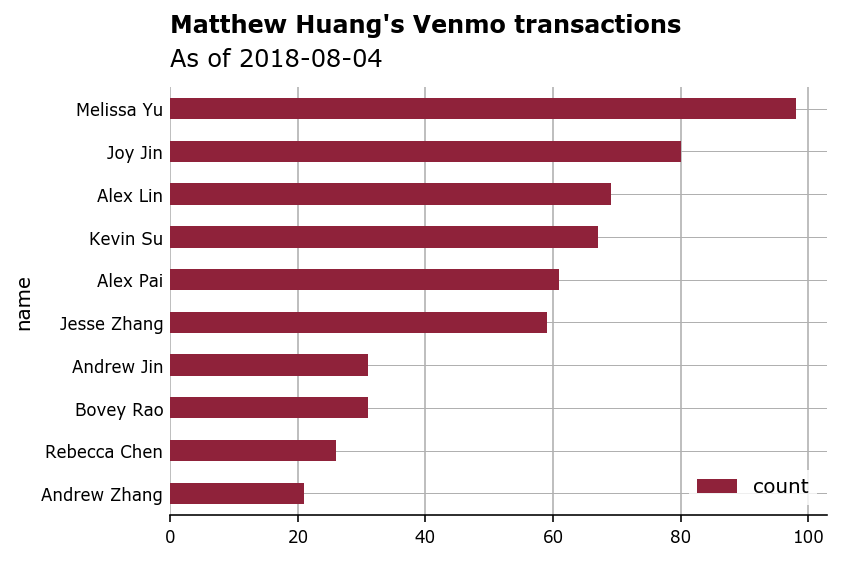

In [415]:
name = 'Matthew Huang'
u_id = users[users.name == name].index[0]
user_transacts = transactions[(transactions['from'] == u_id) | 
                              (transactions.to == u_id)]

counts = (user_transacts['from']
    .where(user_transacts['from'] != u_id, user_transacts.to)
    .to_frame('other')
    .groupby('other')
    .size())

(pd.concat([counts.to_frame('count'), users.name], axis=1)
    .sort_values('count', ascending=True)
    .dropna()
    .set_index('name')
    .iloc[-10:]
    .plot
    .barh())

plt.grid()
plt.legend()
ft_ax(title="%s's Venmo transactions" % name, subtitle='As of 2018-08-04', y=1.1, left_axis=True)

In [70]:
len(transactions)

11482

In [87]:
users.head()

,username,name,firstname,lastname,date_created,cancelled,external_id,is_business,picture
19670682,Hieu-Nguyen-104,Hieu Nguyen,Hieu,Nguyen,2017-03-27T19:59:13,False,2180004209229824955,False,https://s3.amazonaws.com/venmo/no-image.gif
10021397,David-KM-Yang,David Yang,David,Yang,2016-04-09T17:39:24,False,1924812779814912859,False,https://venmopics.appspot.com/u/v2/m/d600dcab-...
6716272,Rlee-nyc,Ryan Lee,Ryan,Lee,2015-10-03T21:02:18,False,1787932289531904552,False,https://venmopics.appspot.com/u/v1/m/6962323d-...
12292093,Michael-Won-2,Michael Won,Michael,Won,2016-07-21T00:47:45,False,1998955500011520430,False,https://venmopics.appspot.com/u/v3/m/6734b1a9-...
14080191,Siavash-Zamirpour,Siavash Zamirpour,Siavash,Zamirpour,2016-09-21T03:23:45,False,2043970112716800939,False,https://s3.amazonaws.com/venmo/no-image.gif


In [257]:
dft\
.merge(users.loc[:,['name']], left_on='from', right_index=True) \
.rename(columns={'name': 'from_name'}) \
.merge(users.loc[:,['name']], left_on='to', right_index=True) \
.rename(columns={'name': 'to_name'}) \
.loc[:,['created_time', 'message', 'from_name', 'to_name']]

,created_time,message,from_name,to_name
56075147cd03c9af22ec9f48,2015-09-27 02:15:35,笨笨到了嘛,Leslie Wang,Yufeng Ling
5621835fcd03c9af222e1c7c,2015-10-16 23:08:15,吃,Hehe Shen,Yufeng Ling
562873fbcd03c9af2284c46b,2015-10-22 05:28:27,Duck,Jiang Li,Yufeng Ling
56cf8708cd03c9af227d2960,2016-02-25 22:58:16,m,Peng Zhu,Yufeng Ling
57f1edad23e064eac0154d7a,2016-10-03 05:33:33,Uuuuuuuuuuu,Peng Zhu,Yufeng Ling
56d325b6cd03c9af22b7e413,2016-02-28 16:52:06,Shipping,Hui 'Helen' Huang,Yufeng Ling
56e5f2c4cd03c9af22e9340c,2016-03-13 23:07:48,Uber,Xingyu Chen,Yufeng Ling
570a9dc5cd03c9af225b8a30,2016-04-10 18:39:00,HCF,Kylie Zhang,Yufeng Ling
5733aa15cd03c9af22421a35,2016-05-11 21:54:29,👕,Kevin Chen,Yufeng Ling
57d209ca23e064eac0091ec6,2016-09-09 01:00:58,📚,Kevin Chen,Yufeng Ling
